# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [ ]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    # Місце для вашого коду
    self.hidden_layer_1 = DenseLayer(num_features, n_hidden_1, name="hidden_1")
    # Другий шар, який складається з 256 нейронів
    # Місце для вашого коду
    self.hidden_layer_2 = DenseLayer(n_hidden_1, n_hidden_2, name="hidden_2")
    # Вихідний шар
    # Місце для вашого коду
    self.output_layer = DenseLayer(n_hidden_2, num_classes, name="output_layer")


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.hidden_layer_1(x)
    x = self.hidden_layer_2(x)

    return self.output_layer(x, activation=1)

In [ ]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Місце для вашого коду
    acc = K.metrics.Accuracy()
    acc.update_state(y_true, tf.argmax(y_pred, axis=1))
    return acc.result()

In [ ]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    # Місце для вашого коду
    train_variables = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    # Місце для вашого коду
    gradient = g.gradient(loss, train_variables)
    # Модифікуємо параметри
    # Місце для вашого коду
    optimizer.apply_gradients(zip(gradient, train_variables))

In [ ]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    # Місце для вашого коду
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        # Місце для вашого коду

        loss = cross_entropy(pred, batch_y)
        loss_history.append(loss)

        acc = accuracy(pred, batch_y)
        accuracy_history.append(acc)

        print(f"{step=}, loss - {loss}, accuracy - {acc}")

step=100, loss - 52.431190490722656, accuracy - 0.94140625
step=200, loss - 37.1729621887207, accuracy - 0.95703125
step=300, loss - 69.53776550292969, accuracy - 0.9296875
step=400, loss - 39.4037971496582, accuracy - 0.94921875
step=500, loss - 32.24540328979492, accuracy - 0.96484375
step=600, loss - 31.757984161376953, accuracy - 0.9609375
step=700, loss - 23.73420524597168, accuracy - 0.97265625
step=800, loss - 42.0706787109375, accuracy - 0.9375
step=900, loss - 35.98823547363281, accuracy - 0.95703125
step=1000, loss - 32.348358154296875, accuracy - 0.96875
step=1100, loss - 28.396202087402344, accuracy - 0.96875
step=1200, loss - 42.86425018310547, accuracy - 0.94921875
step=1300, loss - 48.24212646484375, accuracy - 0.96484375
step=1400, loss - 17.77875518798828, accuracy - 0.9765625
step=1500, loss - 35.2935676574707, accuracy - 0.9609375
step=1600, loss - 39.57228469848633, accuracy - 0.9296875
step=1700, loss - 52.36115264892578, accuracy - 0.953125
step=1800, loss - 33.92

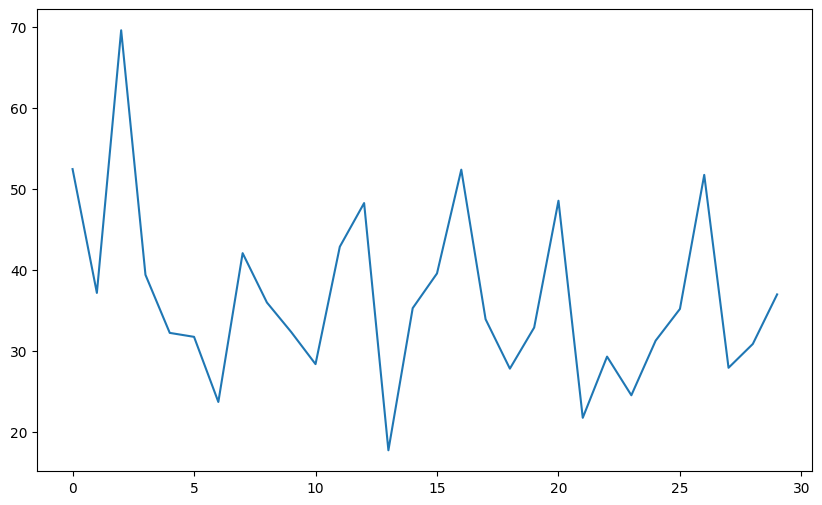

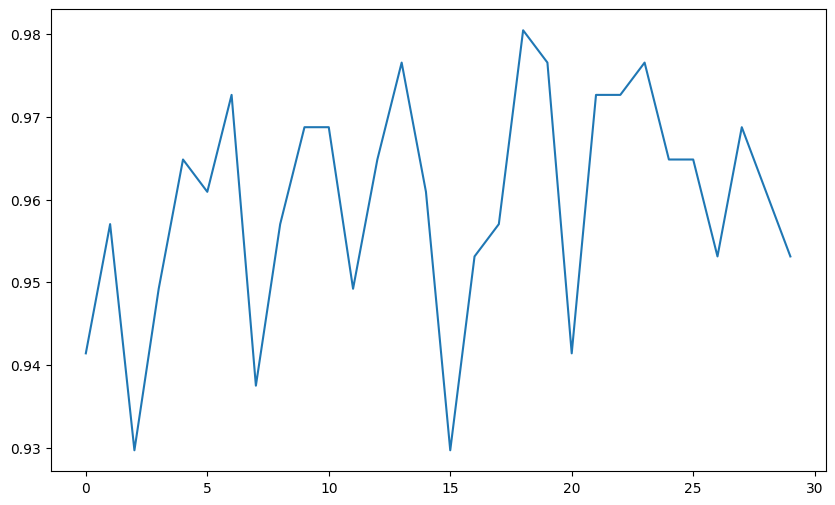

In [ ]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
# Місце для вашого коду
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Loss')
plt.show()
# Виведіть графік точності
# Місце для вашого коду
plt.figure(figsize=(10, 6))
plt.plot(accuracy_history, label='Accuracy')
plt.show()

In [ ]:
# Обчисліть точність навченої нейромережі
# Місце для вашого коду
nn_accuracy = accuracy(neural_net(x_train), y_train)
print(f"Accuracy - {nn_accuracy}")
# Тестування моделі на тестових даних
# Місце для вашого коду
test_nn_accuracy = accuracy(neural_net(x_test), y_test)
print(f"Test data accuracy - {test_nn_accuracy}")

Accuracy - 0.9584166407585144
Test data accuracy - 0.926800012588501


True: 2 Predict: 2 True
True: 7 Predict: 7 True
True: 2 Predict: 2 True
True: 4 Predict: 4 True
True: 3 Predict: 3 True
True: 7 Predict: 7 True
True: 2 Predict: 4 False
True: 7 Predict: 7 True
True: 0 Predict: 0 True
True: 9 Predict: 4 False


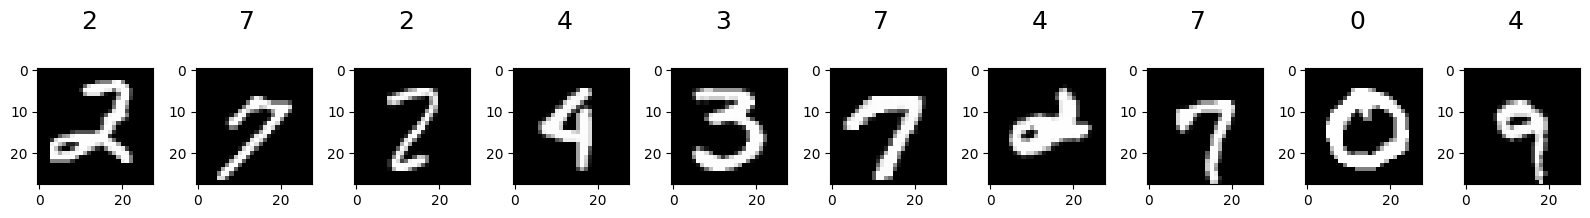

In [ ]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# Місце для вашого коду
test_img = np.random.permutation(x_test.shape[0])[:10]
y_test_true = y_test[test_img]
pred_data = [np.argmax(x) for x in neural_net(x_test[test_img])]

plt.figure(figsize=(16, 6))
for i in range(10):
    print(f"True: {y_test_true[i]} Predict: {pred_data[i]} {True if y_test_true[i] - pred_data[i] == 0 else False}")
    plt.subplot(1, 10, (i + 1))
    plt.imshow(x_test[test_img[i]].reshape(28, 28), cmap='gray')
    plt.text(x=10, y=-10, s=pred_data[i], fontsize=18)

plt.tight_layout()
plt.show()

Маємо два хибних передбачення з 10 тестових випадків.